# MENNPDF with 4D examples

This notebook illustrates the usage of the MENNPDF method over some examples.

## Configuration

In [1]:
import tensorflow as tf
import numpy as np
import scipy.stats as st
from scipy.interpolate import interpn
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource, Normalize
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
import pandas as pd

from mennpdf_multivariate import gaussianKdeInt, SimpleMultiMaxEntrLayer, SimpleMultiMaxEntrModel
from ressources.mmd_tools import sigmaCalc, mmd2u, mmd2uEigValSample, pValueCalc

2025-03-20 15:56:27.509841: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 15:56:27.539180: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 15:56:27.943285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2025-03-20 15:56:28.908686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-20 15:56:28.934350: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-20 15:56:28.934496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Reading the data from the file

In [3]:
df = pd.read_table("ressources/Fr_Longues_24092413.txt", sep=',', header=None)
data = df.iloc[:, :4].to_numpy()
mask = ~np.isnan(data).any(1)    # Select data with at least 4 natural frequency 
dfFull = df.iloc[mask, :4]

sampleRaw = dfFull.to_numpy().T
del df, data, mask, dfFull

minsFreq, maxsFreq = sampleRaw.min(1), sampleRaw.max(1)

# Normalize data
sample =  ((sampleRaw - minsFreq[:, None]) / (maxsFreq - minsFreq)[:, None])

dim, n = sample.shape

Using a Gaussian KDE to generate the integration data with associated weights.

In [4]:
blurryBandwidth = .5
intPts, intWeights =  gaussianKdeInt(2**17, sample, blurryBandwidth)

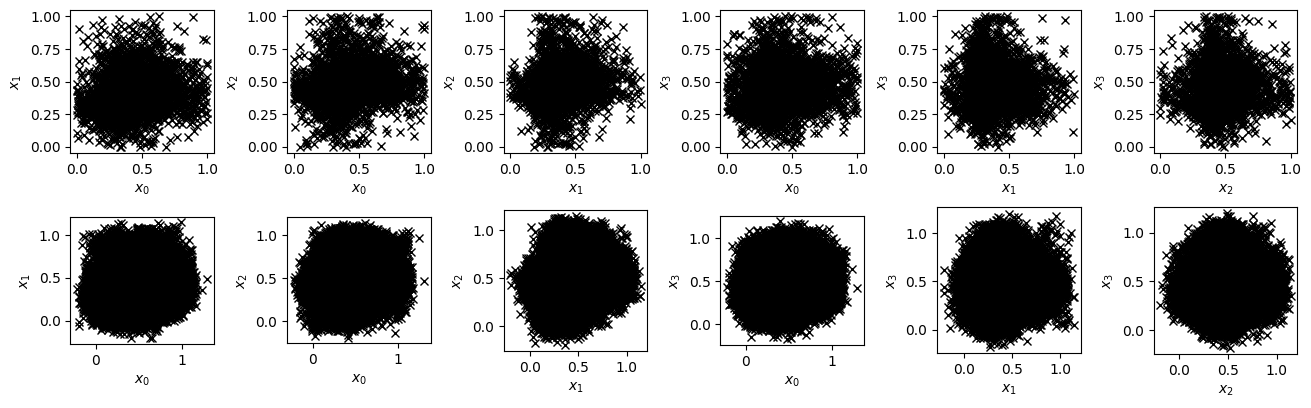

In [5]:
couples = []
for i in range(dim):
    for j in range(i+1):
        if i != j:
            couples.append((j, i))

fig, axs = plt.subplots(2, len(couples), figsize=(13, 4), layout='constrained')

for i, coup in enumerate(couples):
    axs[0, i].plot(sample[coup[0], :], sample[coup[1], :], 'xk')
    axs[0, i].set_aspect('equal')
    axs[1, i].plot(intPts[coup[0], :], intPts[coup[1], :], 'xk')
    axs[1, i].set_aspect('equal')
    for j in [0, 1]:
        axs[j, i].set_xlabel(r"$x_{}$".format(coup[0]))
        axs[j, i].set_ylabel(r"$x_{}$".format(coup[1]))

Definition of the neural network andthe model

In [6]:
gNN = tf.keras.Sequential([
    tf.keras.Input(shape=(dim,)),
    tf.keras.layers.GaussianNoise(0.001),
    tf.keras.layers.Dense(40, activation='swish'),
    tf.keras.layers.Dense(20, activation='swish'),    
    tf.keras.layers.Dense(10, activation='swish'),
    tf.keras.layers.Dense(1, activation='linear')
])

MElay = SimpleMultiMaxEntrLayer(intPts.astype(np.float32).T, intWeights[:, None].astype(np.float32))
MEmod = SimpleMultiMaxEntrModel(gNN, MElay)

In [7]:
gNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,241 (4.85 KB)

 Trainable params: 1,241 (4.85 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
MEmod.compile(optimizer=tf.optimizers.Adam(3e-4))
MEmod.run_eagerly = False
# MEmod.run_eagerly = True
countedEpochs = 0
hist = None

**Training**

In [9]:
epochsToDo = 20000
histKeras = MEmod.fit(x=sample.T, y=None, batch_size=n, epochs=epochsToDo+countedEpochs , initial_epoch=countedEpochs, verbose=0)
countedEpochs += epochsToDo
if hist == None:
    hist = histKeras.history
else:
    {hist[k].extend(v) for k, v in histKeras.history.items()}

I0000 00:00:1742482595.045815 1786127 service.cc:145] XLA service 0x715078009920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742482595.045833 1786127 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-20 15:56:35.064090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-20 15:56:35.168385: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-03-20 15:56:35.963029: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

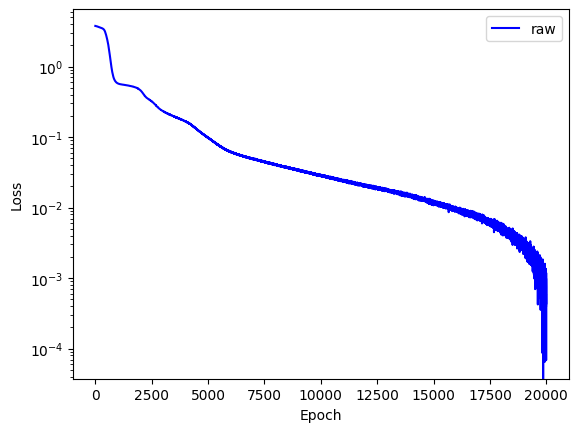

In [10]:
lossFig, lossAx = plt.subplots()

histo = np.array(hist['gamma'])
histo = histo - histo.min()

lossAx.plot(histo, '-b', label="raw")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()

## Results

Generation of a sample with the estimated PDF

In [11]:
sigma = sigmaCalc(sample, sample).astype(np.float32)
nbSamps = 20
trySamps = [MEmod.rvs(n, sample.T, 100, sigma).numpy().T for _ in range(nbSamps)]

In [12]:
mins, maxs = sample.min(1), sample.max(1)
slack = .01
mins, maxs = mins - slack * (maxs - mins), maxs + slack * (maxs - mins)
nbPtsPlot = 200
#Un-uniformize lims
minsFS, maxsFS = minsFreq - slack * (maxsFreq - minsFreq), maxsFreq + slack * (maxsFreq - minsFreq)

Sampling the estimated distribution to evaluate the 1D and 2D PDFs sub-projections by Monte Carlo.

In [13]:
histVals = [np.zeros(nbPtsPlot) for i in range(dim)]
histVal2s = [np.zeros((nbPtsPlot, nbPtsPlot)) for i in range( (dim**2 - dim)//2 )]
histBins = [np.linspace(minsFS[i], maxsFS[i], nbPtsPlot+1) for i in range(dim)]

for k in range(2**0):
    dataHist = None
    dataHist = MEmod.rvs(2**23, sample.T, 100, sigma).numpy()
    dataHist = (maxsFreq - minsFreq) * dataHist + minsFreq

    for i in range(dim):
        for j in range(i+1):

            if i == j:
                tmpHist, _ = np.histogram(dataHist[:, i], bins=histBins[i], density=False)
                histVals[i] += tmpHist

            else:
                ind = (i**2 - i)//2 + j
                tmpHist2, _, _ = np.histogram2d(dataHist[:, i], dataHist[:, j], bins=[histBins[i], histBins[j]], density=False)            
                histVal2s[ind] += tmpHist2


for i in range(dim):
    for j in range(i+1):

        if i == j:
            histVals[i] = nbPtsPlot * histVals[i] / (histVals[i].sum() * (maxsFS[i] - minsFS[i]))
        else:
            ind = (i**2 - i)//2 + j
            histVal2s[ind] = nbPtsPlot**2 * histVal2s[ind] / (histVal2s[ind].sum() * (maxsFS[i] - minsFS[i]) * (maxsFS[j] - minsFS[j]) )

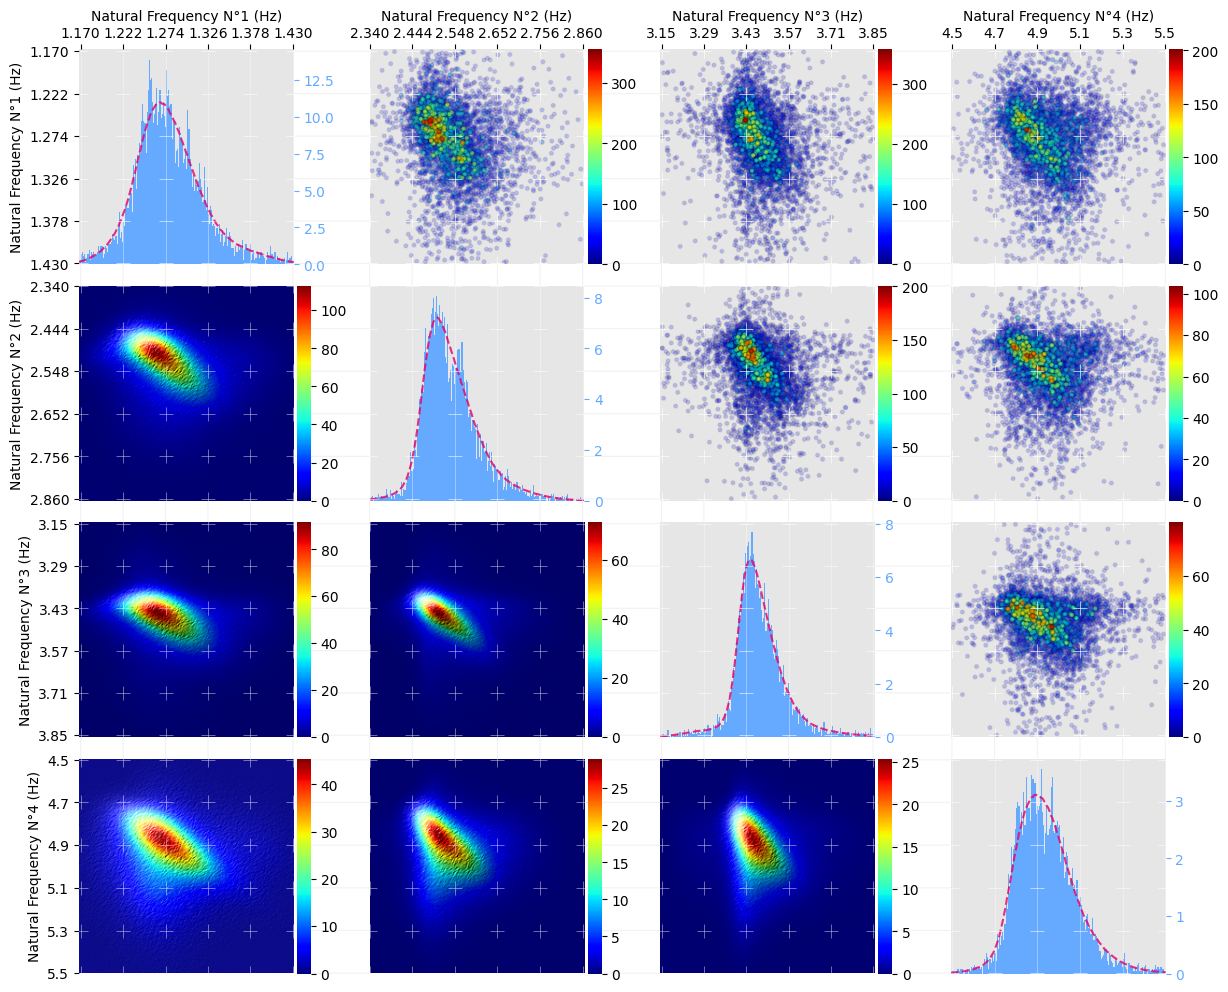

In [ ]:
fig3 = plt.figure(num=2, clear=True)
fig3.set_figheight(12)
fig3.set_figwidth(15)
gs =GridSpec(dim, 2*dim, figure=fig3, width_ratios=[20, 1]*dim, hspace=0.1, wspace=0.)
lightS = LightSource(azdeg=315, altdeg=45)
axDict = {}
axDiagY = []

for i in range(dim):
    for j in range(dim):


        tmpAx = fig3.add_subplot(gs[j, 2*i])
        tmpAx.set_box_aspect(1)

# Scatter plot of the data point in 2D
        if i > j:
            xAxis = sampleRaw[i, :]
            yAxis = sampleRaw[j, :]

            colorHist, _, _ = np.histogram2d(xAxis, yAxis, bins=(histBins[i], histBins[j]), density=True)
            midX = .5 * (histBins[i][1:] + histBins[i][:-1])
            midY = .5 * (histBins[j][1:] + histBins[j][:-1])
            colorList = interpn((midX, midY), colorHist, sampleRaw[(i,j), :].T, method = "splinef2d")
            indSort = colorList.argsort()
            normCol = Normalize(vmin=0,vmax=colorList[indSort[-1]])
            xAxis, yAxis, colorList = xAxis[indSort], yAxis[indSort], normCol(colorList[indSort])

            tmpCmap = plt.cm.jet
            tmpAx.scatter(xAxis, yAxis, c=tmpCmap(colorList, alpha=.2), marker='.', edgecolor='#00000010', linestyle='')
            tmpAx.set_xlim(minsFS[i], maxsFS[i])
            tmpAx.set_ylim(maxsFS[j], minsFS[j])
            tmpAx.set_facecolor('0.9')
            for side in ['top', 'bottom', 'left', 'right']:
                tmpAx.spines[side].set_visible(False)

            colAx = fig3.add_subplot(gs[j, 2*i+1])
            fig3.colorbar(plt.cm.ScalarMappable(norm=normCol, cmap=tmpCmap), cax=colAx)
            colAx.set_frame_on(False)
            

#Plot of the estimated marginal PDF with the associated sample histogram
        if i==j:
            colHist = '#65AAFF'
            xAxis = np.linspace(minsFS[i], maxsFS[i], nbPtsPlot)
            yAxisPdf = histVals[i]
            yAxisSamp, _ = np.histogram(sampleRaw[i, :], bins=histBins[i], density=True)
            tmpAx.stairs(yAxisSamp, edges=histBins[i], fill=True, color=colHist, alpha=1.)
            tmpAx.plot(xAxis, yAxisPdf, marker='', linestyle='--', color='#E70068', alpha=.8)
            tmpAx.set_xlim(minsFS[i], maxsFS[i])
            tmpAx.tick_params(axis='y', colors=colHist)      

            twinAx = tmpAx.twinx()
            twinAx.set_box_aspect(1)
            twinAx.set_ylim(minsFS[i], maxsFS[i])
            twinAx.invert_yaxis()
            twinAx.yaxis.tick_left()
            twinAx.set_frame_on(False)

            tmpAx.yaxis.set_label_position('left')
            tmpAx.yaxis.tick_right()
            tmpAx.grid(True, axis='x', color='w', lw=.5, alpha=.5)
            tmpAx.set_facecolor('0.9')
            for side in ['top', 'bottom', 'left', 'right']:
                tmpAx.spines[side].set_visible(False)
            

# 2D raster of the estimated PDF
        if i < j:
            ind = (j**2 - j)//2 + i  #Finds the associated indice in the list
            zAxis = histVal2s[ind]   # data should be (size of Y, size of X)
            tmpCmap = plt.cm.jet
            shadedAxis = lightS.shade(zAxis, cmap=tmpCmap, blend_mode='hsv', vert_exag=.01)
            im = tmpAx.imshow(shadedAxis,
                              aspect='auto',
                              extent=[minsFS[i], maxsFS[i], maxsFS[j], minsFS[j]],
            )
            colAx = fig3.add_subplot(gs[j, 2*i+1])
            fig3.colorbar(plt.cm.ScalarMappable(norm=Normalize(0., zAxis.max()), cmap=tmpCmap), cax=colAx)
            colAx.set_frame_on(False)
            tmpAx.set_frame_on(False)

# Handling the axis drawing
        xTickNb, yTickNb = 6, 6 
        xTicks = np.linspace(np.ceil(100.*minsFS[i])/100., np.floor(100.*maxsFS[i])/100., xTickNb, endpoint=True)
        yTicks = np.linspace(np.ceil(100.*minsFS[j])/100., np.floor(100.*maxsFS[j])/100., yTickNb, endpoint=True)
        
        tmpAx.set_xlabel('Natural Frequency N°{} (Hz)'.format(i+1), color='k') #Writes the x axis
        tmpAx.xaxis.set_label_position('top')
        if i==j: #Writes the y axis
            twinAx.set_ylabel('Natural Frequency N°{} (Hz)'.format(j+1), color='k')
            twinAx.yaxis.set_label_position('left') 
        else:
            tmpAx.set_ylabel('Natural Frequency N°{} (Hz)'.format(j+1), color='k')

        # x ticks
        tmpAx.xaxis.set_ticks(xTicks)
        tmpAx.xaxis.set_ticks_position('top')

        if j != 0:  #Removes the x axis ticks and label of the plots not at the top 
            for tick in tmpAx.xaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
                tick.label1.set_visible(False)
                tick.label2.set_visible(False)
            tmpAx.xaxis.label.set_visible(False)

        # y ticks
        if i != j:
            tmpAx.yaxis.set_ticks(yTicks)
        else:
            twinAx.yaxis.set_ticks(xTicks)
            if i != 0:    
                for tick in twinAx.yaxis.get_major_ticks():
                    tick.tick1line.set_visible(False)
                    tick.tick2line.set_visible(False)
                    tick.label1.set_visible(False)
                    tick.label2.set_visible(False)
                twinAx.yaxis.label.set_visible(False)
            
        if i != 0 and i != j: #Removes the y axis of the plots not at the left and on the diagonal
                for tick in tmpAx.yaxis.get_major_ticks():
                    tick.tick1line.set_visible(False)
                    tick.tick2line.set_visible(False)
                    tick.label1.set_visible(False)
                    tick.label2.set_visible(False)
                tmpAx.yaxis.label.set_visible(False)

        tmpAx.set_adjustable('datalim')
        
        

        if i != j:  #Shift colorbar to the right
            box = colAx.get_position()
            box.x0, box.x1 = 3 * box.x0 - 2 * box.x1 , 2 * box.x0 - box.x1
            colAx.set_position(box)

        #creating dict for line part
        if i==j:
            axDict.update({str(i)+str(j):twinAx})
            axDiagY.append(tmpAx)
        else:
            axDict.update({str(i)+str(j):tmpAx})
        

#Connector modifiers
conWidth = axDict['10'].get_xgridlines()[0].get_linewidth()
conColor = [.95]*3 # .9 background with 50% alpha of white line
condZorder = -1000.
def conModif(con):
    con.set_color(conColor)
    con.set_linewidth(conWidth)
    con.set_zorder(condZorder)


#Drawing vertical connectors
for i in range(dim):
    for j in range(dim-1):
        axI, axIpp = axDict[str(i)+str(j)], axDict[str(i)+str(j+1)]
        xTicks = [tmpVal.get_position()[0]  for tmpVal in axDict[str(i)+"0"].xaxis.get_ticklabels()]
        axIMax, axIppMin = axI.get_ylim()[0], axIpp.get_ylim()[1]
        for xTick in xTicks:
            con = ConnectionPatch(xyA=(xTick, axIMax), xyB=(xTick, axIppMin), coordsA=axI.transData, coordsB=axIpp.transData)
            conModif(con)
            axI.add_artist(con)
            
#Drawing horizontal connectors
for i in range(dim-1):
    for j in range(dim):
        axI, axIpp = axDict[str(i)+str(j)], axDict[str(i+1)+str(j)]
        yTicks = [tmpVal.get_position()[1]  for tmpVal in axDict["0"+str(j)].yaxis.get_ticklabels()]
        axIMax, axIppMin = axI.get_xlim()[1], axIpp.get_xlim()[0]
        for yTick in yTicks:
            con = ConnectionPatch(xyA=(axIMax, yTick), xyB=(axIppMin, yTick), coordsA=axI.transData, coordsB=axIpp.transData)
            conModif(con)
            if i != j:
                axI.add_artist(con)
            else:
                axDiagY[i].add_artist(con)

# Cross on the diagonal
for i in range(dim):
    tmpAx = axDict[str(i)*2]
    xTicks = [xx.get_position()[0] for xx in axDict[str(i)+'0'].xaxis.get_ticklabels()]
    yTicks = [yy.get_position()[1] for yy in axDict['0'+str(i)].yaxis.get_ticklabels()]
   
    xxTic, yyTic = np.meshgrid(xTicks, yTicks)
    xxTic, yyTic = xxTic.flatten(), yyTic.flatten()

    tmpAx.plot(xxTic, yyTic, marker='_', ls='', mec='w', ms=10, mew=.5 ,alpha=.8, label="grid")

# Grid for pdfs
for i in range(dim-1):
    for j in range(i+1, dim):
        tmpAx = axDict[f"{i}{j}"]
        xTicks = [xx.get_position()[0] for xx in axDict[str(i)+'0'].xaxis.get_ticklabels()]
        yTicks = [yy.get_position()[1] for yy in axDict['0'+str(j)].yaxis.get_ticklabels()]
        
        xxTic, yyTic = np.meshgrid(xTicks, yTicks)
        xxTic, yyTic = xxTic.flatten(), yyTic.flatten()

        tmpAx.plot(xxTic, yyTic, marker='+', ls='', mec='w', ms=10, mew=.5, alpha=.6, label="grid")

# Grid for scatters
for i in range(1, dim):
    for j in range(i):
        tmpAx = axDict[f"{i}{j}"]
        xTicks = [xx.get_position()[0] for xx in axDict[str(i)+'0'].xaxis.get_ticklabels()]
        yTicks = [yy.get_position()[1] for yy in axDict['0'+str(j)].yaxis.get_ticklabels()]
        
        xxTic, yyTic = np.meshgrid(xTicks, yTicks)
        xxTic, yyTic = xxTic.flatten(), yyTic.flatten()

        tmpAx.plot(xxTic, yyTic, marker='+', ls='', mec='w', ms=10, mew=.5, alpha=.9, label="grid")

plt.show()

Assessing the result with the MMD<sub>u</sub><sup>2</sup> metric

In [15]:
pVals = []
for i, trySamp in enumerate(trySamps):
    print(f"Computing run {i+1} out of {nbSamps}")
    idMax = min(sample.shape[0], trySamp.shape[0])
    MMD2u = mmd2u(sample[:idMax, :], trySamp[:idMax, :], sigma=sigma)
    bsSamp = mmd2uEigValSample(sample[:idMax, :], trySamp[:idMax, :], sigma, nbSamp=10000)
    pValue = pValueCalc(bsSamp, MMD2u)
    pVals.append(pValue)
    slideMean = (np.array(pVals) >= .05).mean()
    print(f"-> {pValue} (slide mean: {slideMean})")
pVals = np.array(pVals)

Computing run 1 out of 20
-> 0.0247 (slide mean: 0.0)
Computing run 2 out of 20
-> 0.21669999999999998 (slide mean: 0.5)
Computing run 3 out of 20
-> 0.259 (slide mean: 0.6666666666666666)
Computing run 4 out of 20
-> 0.2845 (slide mean: 0.75)
Computing run 5 out of 20
-> 0.2747 (slide mean: 0.8)
Computing run 6 out of 20
-> 0.775 (slide mean: 0.8333333333333334)
Computing run 7 out of 20
-> 0.16319999999999998 (slide mean: 0.8571428571428571)
Computing run 8 out of 20
-> 0.6138 (slide mean: 0.875)
Computing run 9 out of 20
-> 0.7837999999999999 (slide mean: 0.8888888888888888)
Computing run 10 out of 20
-> 0.3485 (slide mean: 0.9)
Computing run 11 out of 20
-> 0.0006000000000000001 (slide mean: 0.8181818181818182)
Computing run 12 out of 20
-> 0.5744 (slide mean: 0.8333333333333334)
Computing run 13 out of 20
-> 0.42719999999999997 (slide mean: 0.8461538461538461)
Computing run 14 out of 20
-> 0.0608 (slide mean: 0.8571428571428571)
Computing run 15 out of 20
-> 0.1583 (slide mean: 0.

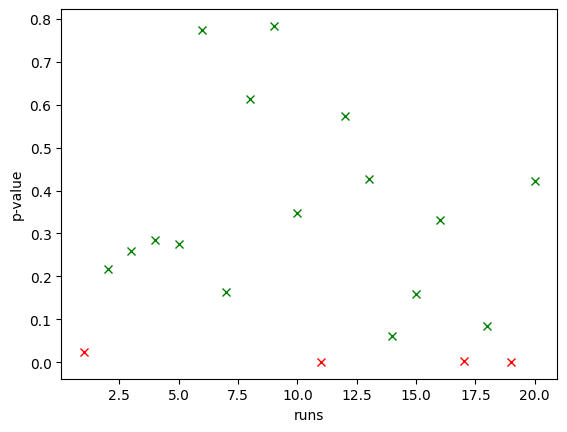

In [16]:
plt.figure()
runs = np.arange(1, pVals.shape[0]+1)
maskPassed = pVals >= .05
plt.plot(runs[maskPassed], pVals[maskPassed], 'xg')
plt.plot(runs[~maskPassed], pVals[~maskPassed], 'xr')
plt.xlabel("runs")
_ = plt.ylabel("p-value")

Counting the runs with p-values above the 5% threshold.

In [17]:
(pVals >= .05).mean()

0.8